# Analyse exploratoire du marché Airbnb sur Oslo
**Auteur :** Jolan (Business Analyst) & Assistant IA (Data Analyst senior virtuel)

**Contexte pédagogique**

Ce notebook s’inscrit dans le cadre du projet de Big Data du Master 2 CMSI.
Dans notre cas, nous avons appliqué la même démarche méthodologique vu en cours sur la ville d’**Oslo**, à partir du dataset simplifié [InsideAirbnb](https://insideairbnb.com/fr/get-the-data/).

**Les objectifs sont :**
1. Comprendre la **structure du marché** (quartiers, types de logements).
2. Analyser les **prix**, identifier les quartiers les plus chers et les facteurs clés.
3. Étudier le **profil des hôtes** (professionnels vs particuliers) et le rôle des avis.
4. Évaluer des **indicateurs de demande** (reviews, disponibilité).
5. Proposer une **segmentation simple** (Budget / Mid / Luxe).
6. Mettre en évidence les **limites, biais** et les choix méthodologiques (outliers, données manquantes).

Les échanges complets avec l’IA (prompts, critiques, itérations) sont fournis
séparément dans un fichier `interaction_IA_oslo.md` / PDF.

*Disclaimer : Cette analyse est basée sur une extraction statique (snapshot) du 29 septembre via les data obtenue sur [InsideAirBnB](https://insideairbnb.com/fr/get-the-data/)*

## Table des matières
1. [Introduction & contexte métier](##1)
2. [Chargement des données](##2)
3. [Compréhension & nettoyage des données](##3)  
4. [Vue d’ensemble du marché](##4)  
5. [Analyse des prix](##5)  
6. [Analyse des hôtes & des avis](##6)  
7. [Indicateurs de demande](##7)  
8. [Segmentation (Budget / Mid / Luxe)](##8)  
9. [Synthèse business & limites de l’analyse](##9)  
10. [Usage de l’IA & réflexivité](##10)

## 2. Chargement des données
On commence par importer les librairies nécessaires, fixer un style graphique lisible
et charger le dataset `listings.csv` en raw depuis mon repo GitHub.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

try:
    df_raw = pd.read_csv("listings.csv")
    print("Données chargées avec succès (local) !")
except FileNotFoundError:
    url = "https://raw.githubusercontent.com/PercyaDJ/dossier-iae/refs/heads/main/listings.csv"
    df_raw = pd.read_csv(url)
    print("Données chargées avec succès (depuis GitHub) !")

print(f"Dimensions initiales du dataset : {df_raw.shape}")

Données chargées avec succès (depuis GitHub) !
Dimensions initiales du dataset : (12160, 18)


## 3. Compréhension & nettoyage des données
Avant toute analyse, on prend le temps de comprendre la structure
des données et de documenter les décisions de nettoyage :
- colonnes disponibles,
- valeurs manquantes,
- types de variables.

In [ ]:
# Informations générales
display(df_raw.head(5))

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,42932,"Charming apartment, Oslo Center, Ro",187463,Cecilie,NaN,Frogner,59.91201,10.72455,Entire home/apt,2166.0,4,55,2025-08-12,0.37,2,2,1,NaN
1,71725,Central big room - ap with balcony,368229,Reidun,NaN,Gamle Oslo,59.90795,10.77987,Private room,467.0,14,59,2025-09-01,0.33,1,257,3,NaN
2,85902,"Eclectic design home, super central",250159,Melissa,NaN,Gamle Oslo,59.91074,10.77232,Entire home/apt,1800.0,2,82,2025-05-21,0.47,1,28,1,NaN
3,149776,Bird's nest in the heart of Oslo,714768,Henrik,NaN,St. Hanshaugen,59.92398,10.74787,Private room,946.0,4,46,2025-08-29,0.27,2,365,2,NaN
4,165218,"Bedroom, nice riverview, in Oslo",787976,Jon,NaN,Sagene,59.93750,10.76554,Private room,NaN,2,32,2025-09-14,0.19,1,0,8,NaN


In [ ]:
# Résumé statistique des variables numériques
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12160 entries, 0 to 12159
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              12160 non-null  int64  
 1   name                            12160 non-null  object 
 2   host_id                         12160 non-null  int64  
 3   host_name                       12156 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   12160 non-null  object 
 6   latitude                        12160 non-null  float64
 7   longitude                       12160 non-null  float64
 8   room_type                       12160 non-null  object 
 9   price                           8703 non-null   float64
 10  minimum_nights                  12160 non-null  int64  
 11  number_of_reviews               12160 non-null  int64  
 12  last_review                     

In [ ]:
# Valeurs manquantes par colonne
missing_values = df_raw.isnull().sum()
missing_values[missing_values > 0]

,0
host_name,4
neighbourhood_group,12160
price,3457
last_review,2051
reviews_per_month,2051
license,12160


**Commentaires sur les données brutes**
- `neighbourhood_group` et `license` sont vides dans ce snapshot : on ne les utilisera pas.
- `last_review` et `reviews_per_month` présentent des valeurs manquantes :
  typiquement, pas d’avis = 0 review (logements nouveaux ou peu actifs).
- La colonne `price` n’est pas renseignée pour une part significative des annonces
  (≈ 30 %). Pour une analyse économique, ces lignes ne peuvent pas être exploitées,
  on le documente explicitement.

On va maintenant créer un DataFrame de travail `df` :
- copier les données brutes pour ne jamais écraser `df_raw`,
- convertir `last_review` en date,
- remplacer les `NaN` de `reviews_per_month` par 0,
- **supprimer les lignes sans prix**.


In [ ]:
df = df_raw.copy()

# Conversion de la date de dernier avis
if "last_review" in df.columns:
    df["last_review"] = pd.to_datetime(df["last_review"], errors="coerce")

# reviews_per_month : NaN -> 0 (pas d'avis)
if "reviews_per_month" in df.columns:
    df["reviews_per_month"] = df["reviews_per_month"].fillna(0)

# Suppression des annonces sans prix
initial_rows = len(df)
df = df[~df["price"].isna()].copy()
removed_no_price = initial_rows - len(df)

print(f"Lignes initiales : {initial_rows}")
print(f"Lignes supprimées sans prix : {removed_no_price}")
print(f"Lignes restantes pour l'analyse économique : {len(df)}")
print("Nettoyage basique terminé.")

Lignes initiales : 12160
Lignes supprimées sans prix : 3457
Lignes restantes pour l'analyse économique : 8703
Nettoyage basique terminé.


**Décision de nettoyage sur prix manquants**

Nous écartons les annonces sans `price` car :
- elles ne permettent pas de calculer des statistiques de prix,
- les garder introduirait un biais (elles seraient parfois filtrées implicitement
  par les méthodes statistiques sans être documentées).
Cette décision réduit l’échantillon mais augmente la cohérence de l’analyse économique.

## 4. Vue d’ensemble du marché
Questions du cahier des charges :
- Combien de listings au total ?
- Combien de listings par **quartier** (`neighbourhood`) ?
- Quels types de logements (`room_type`) et leur importance ?
- Y a-t-il une **structure de marché** particulière
  (concentration dans certains quartiers, prédominance d’un type de logement) ?

In [ ]:
total_listings = len(df)
print(f"Nombre total de listings exploitables (avec un prix) : {total_listings}")

Nombre total de listings exploitables (avec un prix) : 8703


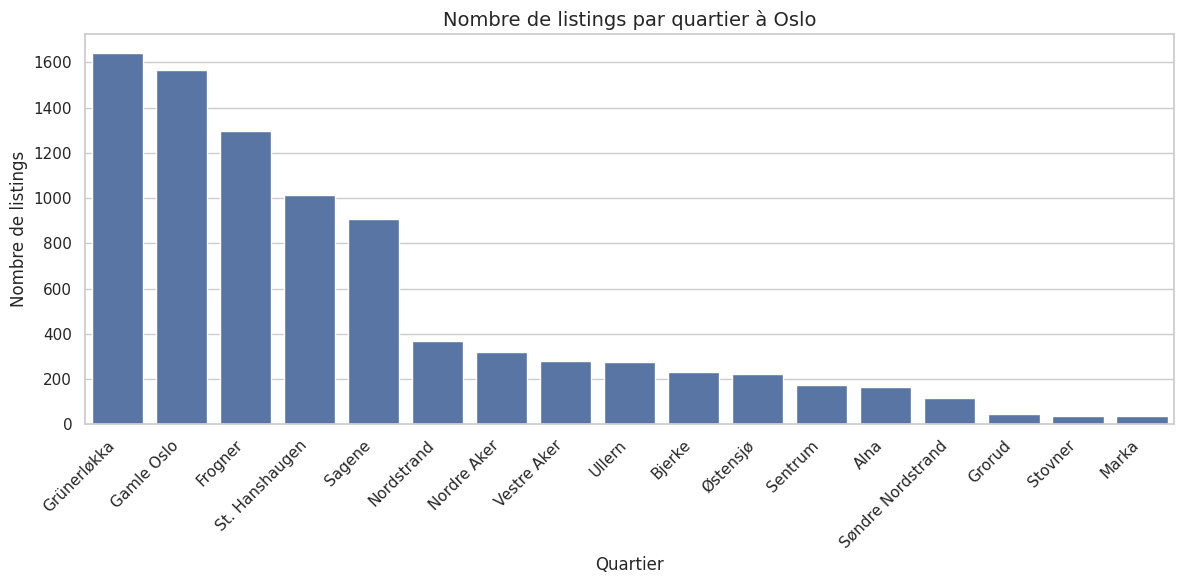

,count
neighbourhood,
Grünerløkka,1642
Gamle Oslo,1566
Frogner,1297
St. Hanshaugen,1016
Sagene,909
Nordstrand,370
Nordre Aker,321
Vestre Aker,278
Ullern,275


In [ ]:
# Répartition par quartier
neigh_counts = df["neighbourhood"].value_counts()

plt.figure()
sns.barplot(x=neigh_counts.index, y=neigh_counts.values)
plt.xticks(rotation=45, ha="right")
plt.title("Nombre de listings par quartier à Oslo")
plt.xlabel("Quartier")
plt.ylabel("Nombre de listings")
plt.tight_layout()
plt.show()

neigh_counts

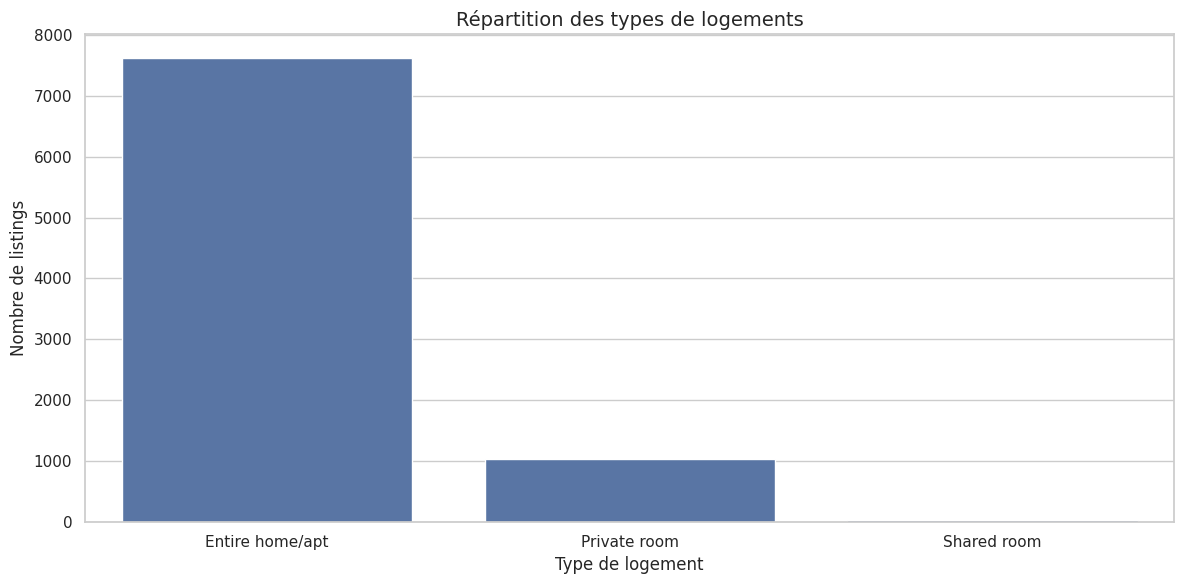

,count
room_type,
Entire home/apt,7624
Private room,1041
Shared room,38


In [ ]:
# Répartition par type de logement
room_counts = df["room_type"].value_counts()

plt.figure()
sns.barplot(x=room_counts.index, y=room_counts.values)
plt.title("Répartition des types de logements")
plt.xlabel("Type de logement")
plt.ylabel("Nombre de listings")
plt.tight_layout()
plt.show()

room_counts

In [ ]:
# Structure croisée Quartier x Type de logement
neigh_room = pd.crosstab(df["neighbourhood"], df["room_type"])
neigh_room

room_type,Entire home/apt,Private room,Shared room
neighbourhood,,,
Alna,94,69,2
Bjerke,193,40,0
Frogner,1175,122,0
Gamle Oslo,1378,175,13
Grorud,29,15,1
Grünerløkka,1448,192,2
Marka,33,4,0
Nordre Aker,297,24,0
Nordstrand,331,38,1


**Insights business : vue d’ensemble**
- Le marché est concentré dans un nombre limité de quartiers dominants
  (on le voit à la distribution très inégale des listings par `neighbourhood`).
- Le type de logement majoritaire est généralement l’**entier logement**
  (`Entire home/apt`), ce qui confirme un positionnement fortement orienté
  vers le tourisme (familles, couples, groupes) plutôt que la simple
  chambre chez l’habitant.
- Certains quartiers combinent un volume important d’annonces et une forte
  proportion de logements entiers : ce sont les **cœurs du marché**.
  D’autres quartiers très peu représentés peuvent être soit des niches,
  soit des zones moins attractives.


## 5. Analyse des prix
Questions du cahier des charges :
- Quels sont les **quartiers les plus chers** ?
- Quels **facteurs** semblent influencer le prix ?
- Y a-t-il des **outliers importants** ? Faut-il les retirer ? Pourquoi ?
On commence par regarder la distribution brute des prix,
puis on discute de la gestion des valeurs extrêmes.

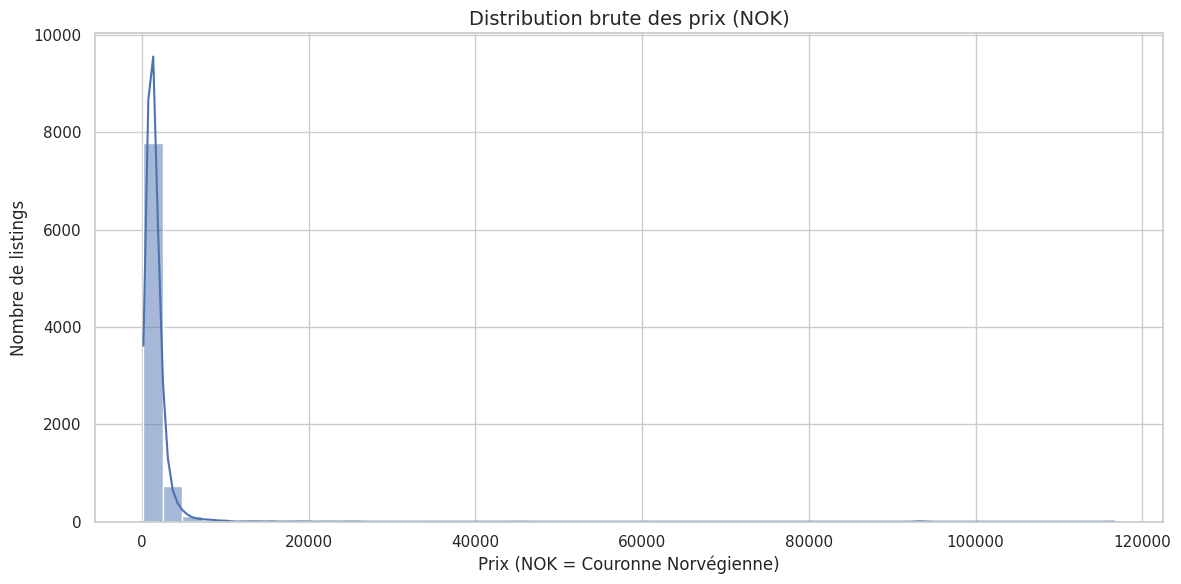

In [ ]:
plt.figure()
sns.histplot(df["price"], bins=50, kde=True)
plt.title("Distribution brute des prix (NOK)")
plt.xlabel("Prix (NOK = Couronne Norvégienne)")
plt.ylabel("Nombre de listings")
plt.tight_layout()
plt.show()

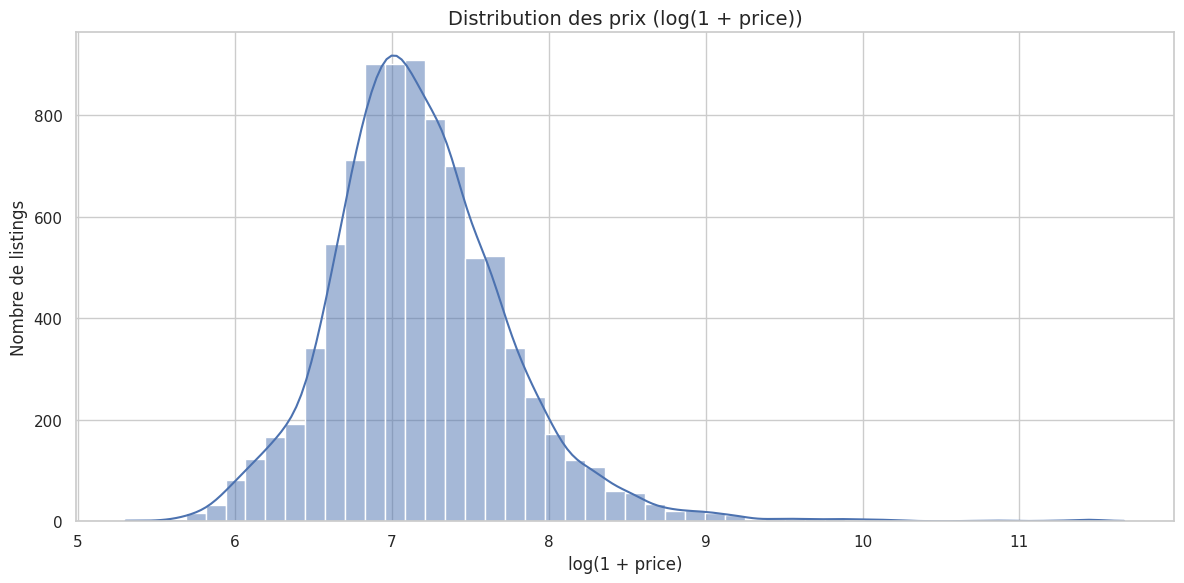

In [ ]:
# Distribution en échelle log (pour mieux voir la queue droite)
plt.figure()
sns.histplot(np.log1p(df["price"]), bins=50, kde=True)
plt.title("Distribution des prix (log(1 + price))")
plt.xlabel("log(1 + price)")
plt.ylabel("Nombre de listings")
plt.tight_layout()
plt.show()

In [ ]:
# Quelques listings les plus chers (pour voir les extrêmes)
df.nlargest(10, "price")[["name", "neighbourhood", "room_type", "price", "availability_365"]]

,name,neighbourhood,room_type,price,availability_365
10506,4 bedroom beautiful apartment in Oslo,St. Hanshaugen,Entire home/apt,116677.0,37
9749,Ferienwohnung für 4 Personen ca. 44 m sup2 in.,Frogner,Entire home/apt,93342.0,250
9750,Ferienwohnung für 2 Personen ca. 50 m sup2 in.,Frogner,Entire home/apt,93342.0,232
9751,Ferienwohnung für 4 Personen ca. 62 m sup2 in.,Frogner,Entire home/apt,93342.0,211
9752,Ferienwohnung für 2 Personen ca. 50 m sup2 in.,Frogner,Entire home/apt,93342.0,220
9753,Ferienwohnung für 4 Personen ca. 86 m sup2 in.,Frogner,Entire home/apt,93342.0,362
10850,Rom i toppetasjen med utsikt!,Bjerke,Private room,80000.0,365
411,Beautiful and quiet location yet central.,Gamle Oslo,Entire home/apt,71500.0,90
1070,maison champfleur,Frogner,Entire home/apt,55496.0,270
10337,Overnatting med garasje. Heis. Terrasse.,Grorud,Entire home/apt,52430.0,84


### 5.1. Stratégies possibles pour gérer les outliers
Plusieurs options existent pour traiter les annonces aux prix extrêmes :
- **Stratégie A : IQR (Interquartile Range)**  
  On calcule Q1, Q3 et on supprime les valeurs au-delà de `Q3 + k * IQR`
  (avec `k` = 1.5 ou 3).
- **Stratégie B : Percentiles**  
  On garde par exemple les prix entre le 1er et le 99e percentile.
  Cela permet de préserver le **vrai haut de gamme** tout en éliminant
  les quelques valeurs aberrantes (erreurs de saisie, annonces peu représentatives).
  
Dans ce notebook, après analyse et arbitrage, on retiens la **stratégie B** :
conserver les prix entre le 1er et le 99e percentile, afin de :
- garder la quasi-totalité du marché, y compris le segment Luxe (les pays du Nord étant chère d'office)
- éviter de tronquer 30 % du dataset comme avec un IQR trop agressif

In [ ]:
# Calcul des bornes par percentiles
lower_bound = df["price"].quantile(0.01)
upper_bound = df["price"].quantile(0.99)

print(f"Borne basse (1er percentile) : {lower_bound:.0f} NOK")
print(f"Borne haute (99e percentile) : {upper_bound:.0f} NOK")

df_clean = df[(df["price"] >= lower_bound) & (df["price"] <= upper_bound)].copy()
print(f"Nombre de listings avant filtrage : {len(df)}")
print(f"Nombre de listings après filtrage : {len(df_clean)}")
print(f"Listings supprimés (outliers extrêmes) : {len(df) - len(df_clean)}")

Borne basse (1er percentile) : 400 NOK
Borne haute (99e percentile) : 7199 NOK
Nombre de listings avant filtrage : 8703
Nombre de listings après filtrage : 8533
Listings supprimés (outliers extrêmes) : 170


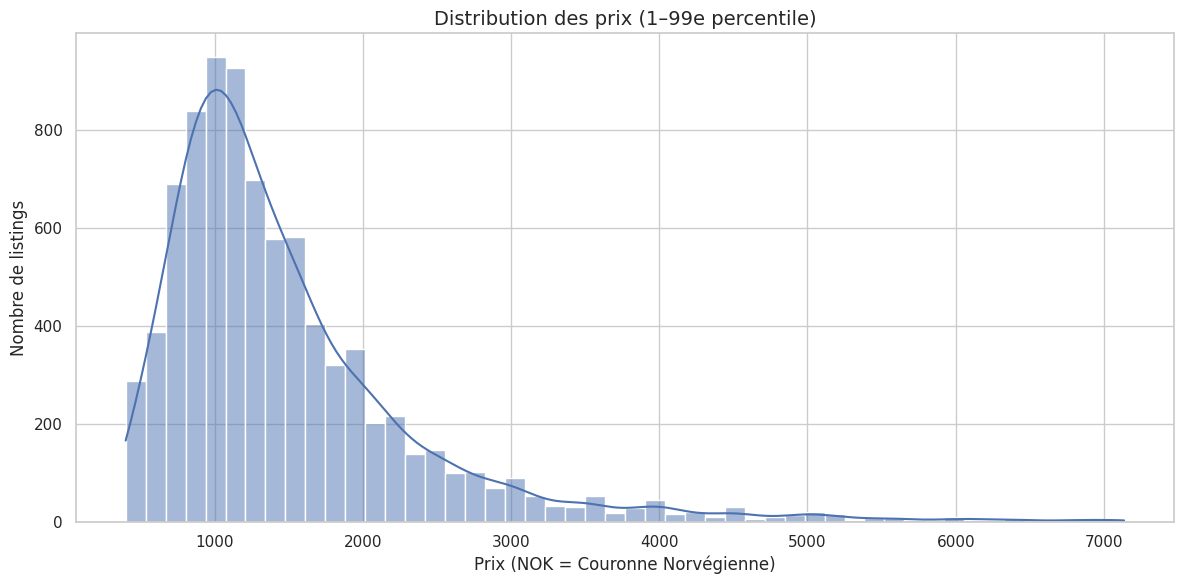

In [ ]:
# Distribution des prix après filtrage
plt.figure()
sns.histplot(df_clean["price"], bins=50, kde=True)
plt.title("Distribution des prix (1–99e percentile)")
plt.xlabel("Prix (NOK = Couronne Norvégienne)")
plt.ylabel("Nombre de listings")
plt.tight_layout()
plt.show()

### 5.2. Quartiers les plus chers
On regarde maintenant les prix par quartier sur les données nettoyées.

In [ ]:
# Prix médian par quartier (plus robuste que la moyenne)
price_by_neigh = (
    df_clean.groupby("neighbourhood")["price"]
    .median()
    .sort_values(ascending=False)
)

price_by_neigh

,price
neighbourhood,
Nordstrand,1601.0
Vestre Aker,1524.5
Frogner,1448.0
Sentrum,1442.5
Ullern,1300.0
St. Hanshaugen,1276.0
Marka,1260.0
Gamle Oslo,1254.0
Nordre Aker,1248.5


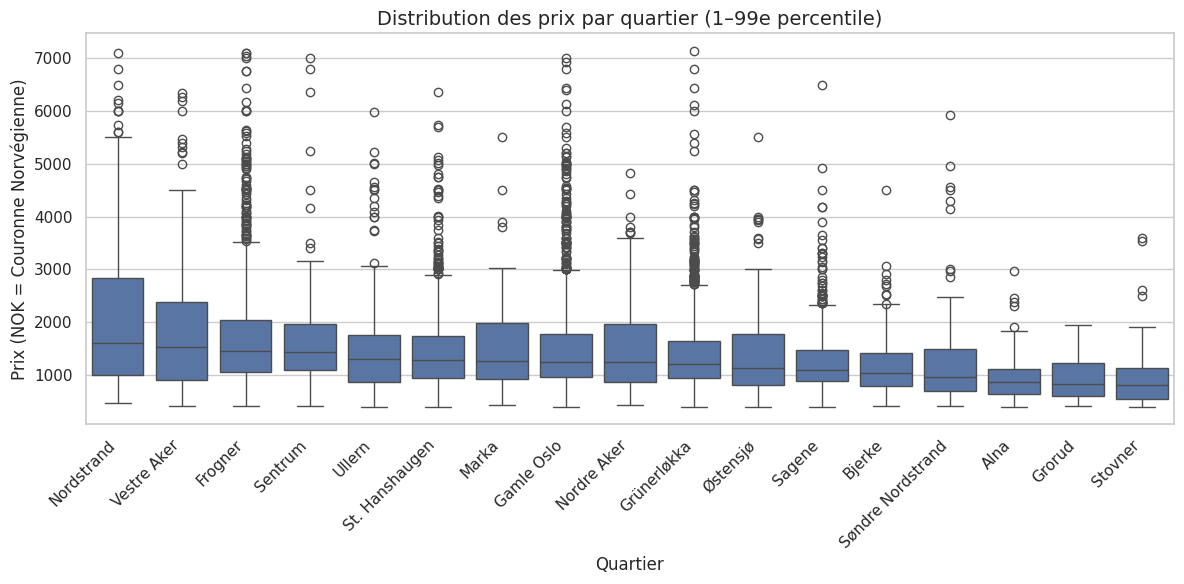

In [ ]:
plt.figure()
sns.boxplot(
    data=df_clean,
    x="neighbourhood",
    y="price",
    order=price_by_neigh.index,
)
plt.xticks(rotation=45, ha="right")
plt.title("Distribution des prix par quartier (1–99e percentile)")
plt.xlabel("Quartier")
plt.ylabel("Prix (NOK = Couronne Norvégienne)")
plt.tight_layout()
plt.show()

**Insights business : quartiers les plus chers**
- Le classement des médianes montre clairement quels quartiers sont
  **premium** (médiane élevée, forte proportion de logements chers)
  et lesquels sont plus **abordables**.
- La forme des boxplots (taille de la boîte, présence de points extrêmes)
  donne une idée de l’hétérogénéité des prix à l’intérieur de chaque quartier.

### 5.3. Facteurs qui influencent le prix
On teste maintenant l’impact de quelques variables clés :
- Quartier (`neighbourhood`)
- Type de logement (`room_type`)
- Nombre minimum de nuits (`minimum_nights`)
- Indicateurs de demande (`number_of_reviews`, `reviews_per_month`)

In [ ]:
# Prix moyen par type de logement
price_by_room = df_clean.groupby("room_type")["price"].median().sort_values(ascending=False)
price_by_room

,price
room_type,
Entire home/apt,1320.0
Shared room,695.0
Private room,673.0


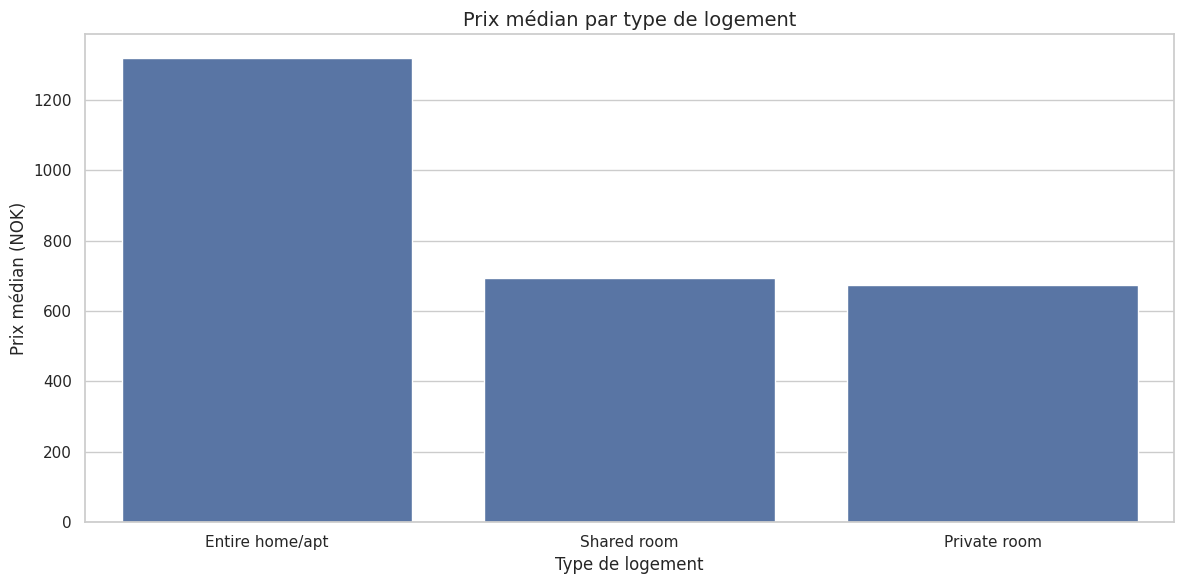

In [ ]:
plt.figure()
sns.barplot(x=price_by_room.index, y=price_by_room.values)
plt.title("Prix médian par type de logement")
plt.xlabel("Type de logement")
plt.ylabel("Prix médian (NOK)")
plt.tight_layout()
plt.show()

In [ ]:
# Corrélation linéaire entre price et quelques variables numériques
num_cols = ["price", "minimum_nights", "number_of_reviews", "reviews_per_month", "availability_365", "calculated_host_listings_count"]
corr = df_clean[num_cols].corr()["price"].sort_values(ascending=False)
corr

,price
price,1.000000
availability_365,0.108550
minimum_nights,-0.031621
calculated_host_listings_count,-0.044945
number_of_reviews,-0.100997
reviews_per_month,-0.170588


**Insights business : facteurs de prix**
- Le **quartier** reste le déterminant principal du niveau de prix :
  les quartiers centraux / “prestige” affichent des médianes nettement plus élevées.
- Le **type de logement** joue aussi un rôle important :
  les logements entiers sont plus chers que les chambres privées,
  ce qui reflète une capacité d’accueil plus grande et un niveau de confort différent.
- Les corrélations montrent que :
  - `minimum_nights` est faiblement corrélée positivement au prix
    (séjours plus longs, biens plus haut de gamme),
  - `number_of_reviews` ou `reviews_per_month` ont une corrélation
    faible avec le prix (les logements très chers peuvent avoir moins de volume),
  - `availability_365` reflète plutôt la stratégie de l’hôte
    (calendrier ouvert/fermé) que le niveau de prix mais reste plus corrélée que les facteurs si dessus.

## 6. Analyse des hôtes & des avis
Questions :
- Les **superhosts** facturent-ils plus cher ? (s’ils existent dans le dataset)
- Le **nombre d’avis** est-il lié à la disponibilité ou au prix ?
- Y a-t-il des **hôtes professionnels** (multi-listings) ?

### 6.1. Superhosts
Dans ce dataset simplifié, il n’y a pas de colonne `host_is_superhost`.
On ne peut donc pas analyser directement la différence de prix entre superhosts
et hôtes “classiques”. C'est donc une **limite de données**.

### 6.2. Hôtes professionnels (multi-listings)
On utilise la colonne `calculated_host_listings_count` comme proxy :
- Hôte professionnel : au moins 3 annonces actives,
- Hôte particulier : moins de 3 annonces.


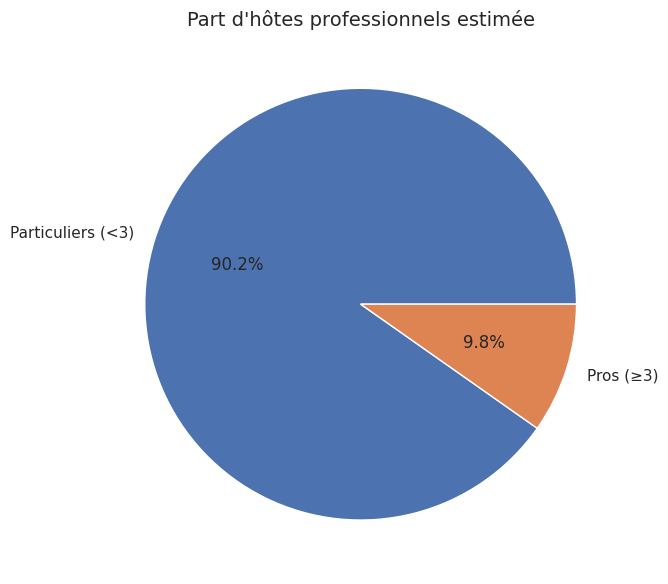

In [ ]:
threshold_pro = 3
df_clean["is_pro"] = df_clean["calculated_host_listings_count"] >= threshold_pro

pro_share = df_clean["is_pro"].value_counts(normalize=True) * 100
pro_share

plt.figure()
pro_share.plot(kind="pie", autopct="%1.1f%%", labels=["Particuliers (<3)", "Pros (≥3)"], ylabel="")
plt.title("Part d'hôtes professionnels estimée")
plt.tight_layout()
plt.show()

In [ ]:
# Impact sur le prix
mean_price_by_pro = df_clean.groupby("is_pro")["price"].mean()
mean_price_by_pro

,price
is_pro,
False,1497.505389
True,1433.272837


**Insight : professionnalisation**
- La part d’hôtes avec plusieurs annonces donne une indication du **niveau de
  professionnalisation** du marché.
- Dans ce dataset, les hôtes professionnels pratiquent des prix moyens
  **plus bas** que les particuliers :
  cela s’interprète comme une stratégie de **standardisation/volume**
  (studios, petits appartements optimisés) contre des particuliers qui louent
  parfois leur résidence principale plus grande ou plus “unique”.

### 6.3. Nombre d’avis vs prix et disponibilité
On explore maintenant le lien entre :
- `number_of_reviews` et `price`,
- `number_of_reviews` et `availability_365`.

In [ ]:
# Corrélations simple
df_clean[["price", "number_of_reviews", "availability_365"]].corr()

,price,number_of_reviews,availability_365
price,1.000000,-0.100997,0.108550
number_of_reviews,-0.100997,1.000000,0.006093
availability_365,0.108550,0.006093,1.000000


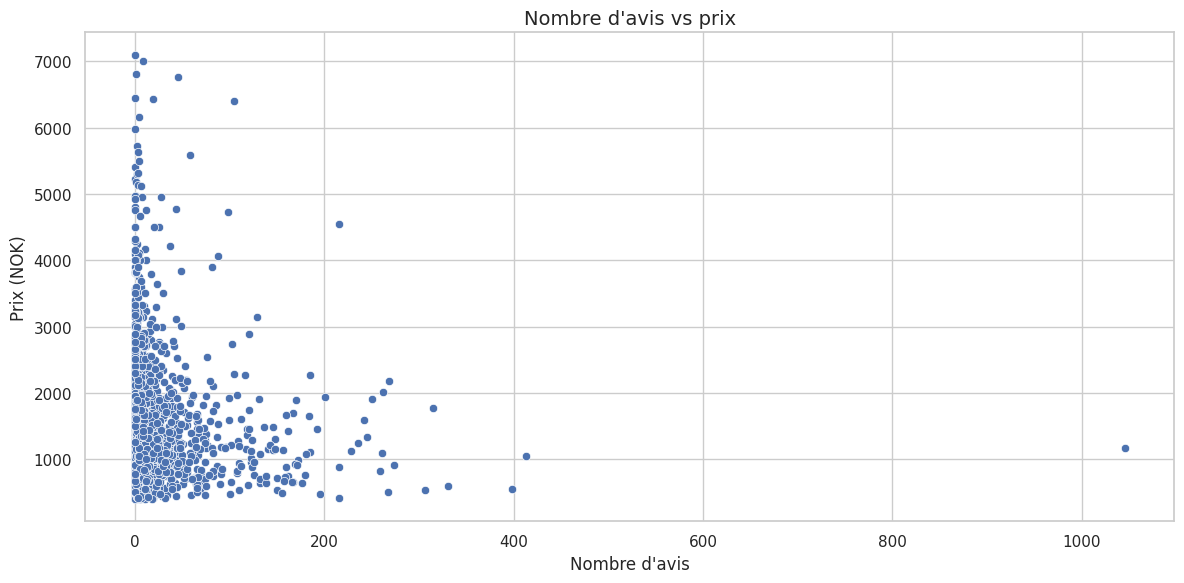

In [ ]:
# Scatter reviews vs price
plt.figure()
sns.scatterplot(
    data=df_clean.sample(min(2000, len(df_clean))),
    x="number_of_reviews",
    y="price",
)
plt.title("Nombre d'avis vs prix")
plt.xlabel("Nombre d'avis")
plt.ylabel("Prix (NOK = Couronne Norvégienne)")
plt.tight_layout()
plt.show()

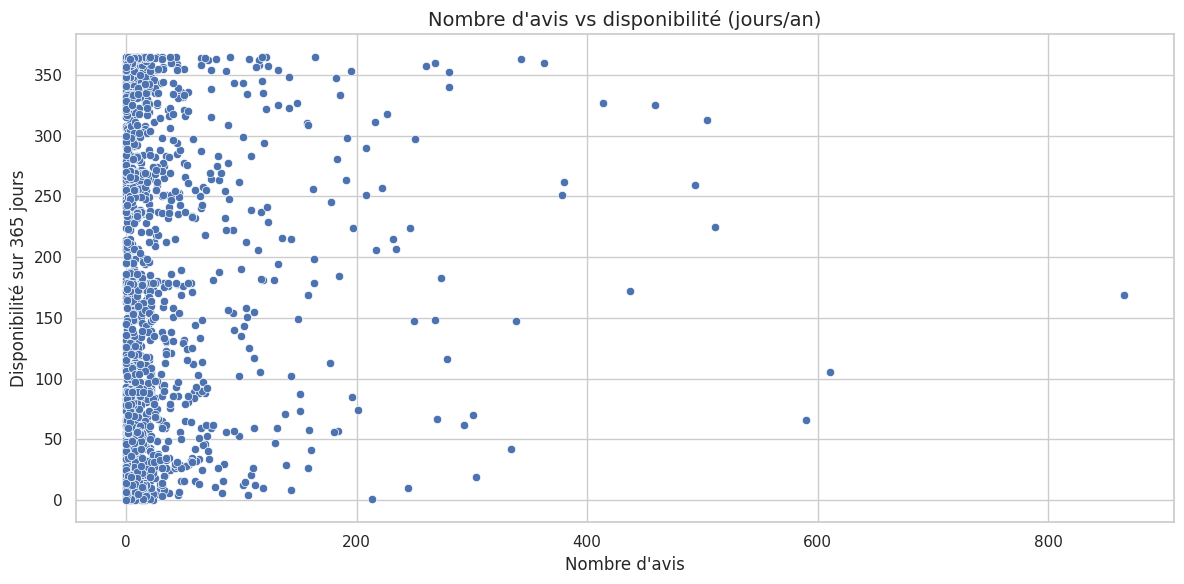

In [ ]:
# Scatter reviews vs availability
plt.figure()
sns.scatterplot(
    data=df_clean.sample(min(2000, len(df_clean))),
    x="number_of_reviews",
    y="availability_365",
)
plt.title("Nombre d'avis vs disponibilité (jours/an)")
plt.xlabel("Nombre d'avis")
plt.ylabel("Disponibilité sur 365 jours")
plt.tight_layout()
plt.show()

**Insights : avis, prix & disponibilité**
- La corrélation entre `number_of_reviews` et `price` est faible :
  les logements très chers ne sont pas nécessairement ceux qui ont le plus de volume.
- Le lien entre `number_of_reviews` et `availability_365` est plus complexe :
  - faible disponibilité + beaucoup d’avis = signal de **forte demande**,  
  - faible disponibilité + peu d’avis = logement **fermé, peu actif ou potentiellement nouveau logement**.
Il faut donc manier ces indicateurs avec prudence : ils sont utiles,
mais ne suffisent pas à eux seuls pour mesurer la demande réelle.

## 7. Indicateurs de demande
Questions :
- Disponibilité moyenne selon les quartiers,
- Quartiers les plus recherchés,
- Saisonnalité potentielle (si disponible).

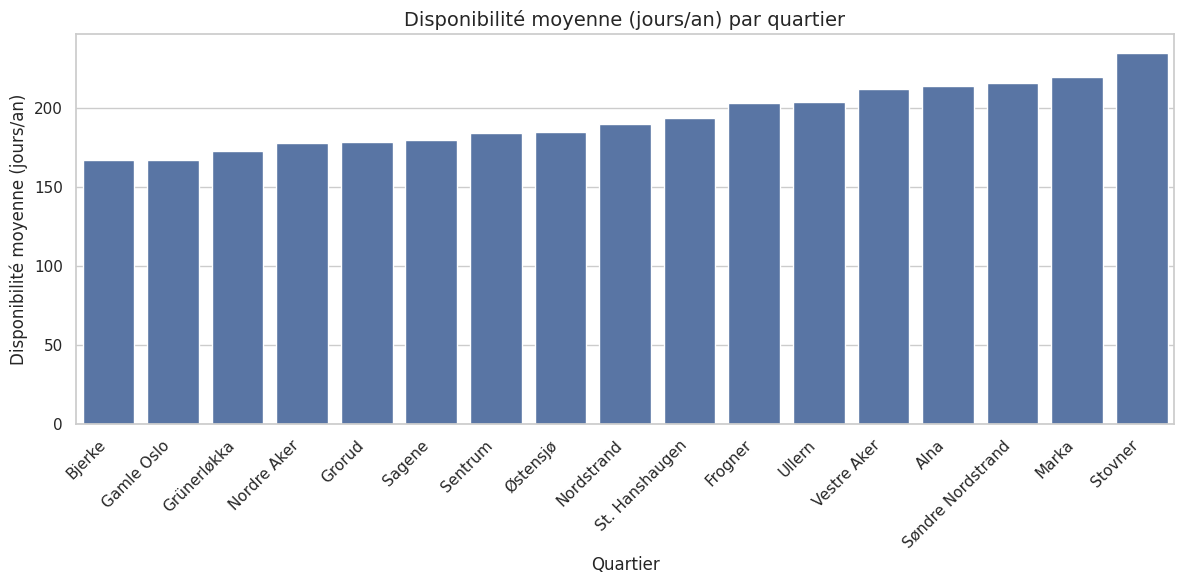

In [ ]:
# Disponibilité moyenne par quartier
availability_by_neigh = (
    df_clean.groupby("neighbourhood")["availability_365"]
    .mean()
    .sort_values()
)

availability_by_neigh

plt.figure()
sns.barplot(
    x=availability_by_neigh.index,
    y=availability_by_neigh.values,
)
plt.xticks(rotation=45, ha="right")
plt.title("Disponibilité moyenne (jours/an) par quartier")
plt.xlabel("Quartier")
plt.ylabel("Disponibilité moyenne (jours/an)")
plt.tight_layout()
plt.show()

In [ ]:
# Indicateur simple de "tension" de la demande :
# beaucoup d'avis récents + faible disponibilité
df_clean["demand_score"] = df_clean["number_of_reviews_ltm"] / (1 + df_clean["availability_365"])

demand_by_neigh = (
    df_clean.groupby("neighbourhood")["demand_score"]
    .mean()
    .sort_values(ascending=False)
)

demand_by_neigh

,demand_score
neighbourhood,
Sentrum,0.537547
Gamle Oslo,0.325496
Frogner,0.313529
St. Hanshaugen,0.274523
Søndre Nordstrand,0.270216
Grünerløkka,0.252762
Østensjø,0.239730
Nordre Aker,0.231217
Nordstrand,0.188464


**Insights : demande & quartiers recherchés**
- Les quartiers avec **faible disponibilité moyenne** et **fort demand_score**
  combinent des signaux de tension : ce sont les quartiers considérés comme **quartiers les plus recherchés**.
- À l’inverse, une forte disponibilité et peu d’avis peuvent révéler des zones
  moins demandées, ou des biens moins compétitifs.

**Saisonnalité**

Le dataset utilisé ici est un snapshot sur une date donnée
et ne contient pas de données de calendrier détaillé par jour.
Il n’est donc **pas possible** d’analyser finement la saisonnalité
(été/hiver, week-end vs semaine) à partir de ce fichier uniquement.
C’est une limite importante de l’analyse. La saisonnalité est importante pour les pays du Nord car ce n'est pas du tout le même tourisme en été et en hiver.

## 8. Segmentation (Budget / Mid / Luxe)
Le cahier des charges encourage une segmentation du marché en grands segments :
Budget / Mid-range / Luxe.
On utilise une segmentation simple par prix, basée sur les terciles (33 % / 33 % / 33 %)
sur `df_clean`.

In [ ]:
p33 = df_clean["price"].quantile(0.33)
p66 = df_clean["price"].quantile(0.66)

def segment_price(p):
    if p < p33:
        return "Budget"
    elif p < p66:
        return "Mid-Range"
    else:
        return "Luxe"

df_clean["segment"] = df_clean["price"].apply(segment_price)

print(f"Seuil Budget : < {p33:.0f} NOK")
print(f"Seuil Luxe   : > {p66:.0f} NOK")
df_clean["segment"].value_counts(normalize=True) * 100

Seuil Budget : < 1022 NOK
Seuil Luxe   : > 1537 NOK


,proportion
segment,
Luxe,33.997422
Mid-Range,33.083324
Budget,32.919255


In [ ]:
# Répartition des segments par quartier
ct = pd.crosstab(df_clean["neighbourhood"], df_clean["segment"])
ct_norm = ct.div(ct.sum(axis=1), axis=0)

ct_norm

segment,Budget,Luxe,Mid-Range
neighbourhood,,,
Alna,0.644295,0.080537,0.275168
Bjerke,0.478070,0.166667,0.355263
Frogner,0.233858,0.456693,0.309449
Gamle Oslo,0.298108,0.337247,0.364644
Grorud,0.595238,0.166667,0.238095
Grünerløkka,0.331085,0.301042,0.367872
Marka,0.305556,0.361111,0.333333
Nordre Aker,0.373418,0.363924,0.262658
Nordstrand,0.256267,0.518106,0.225627


<Figure size 1200x600 with 0 Axes>

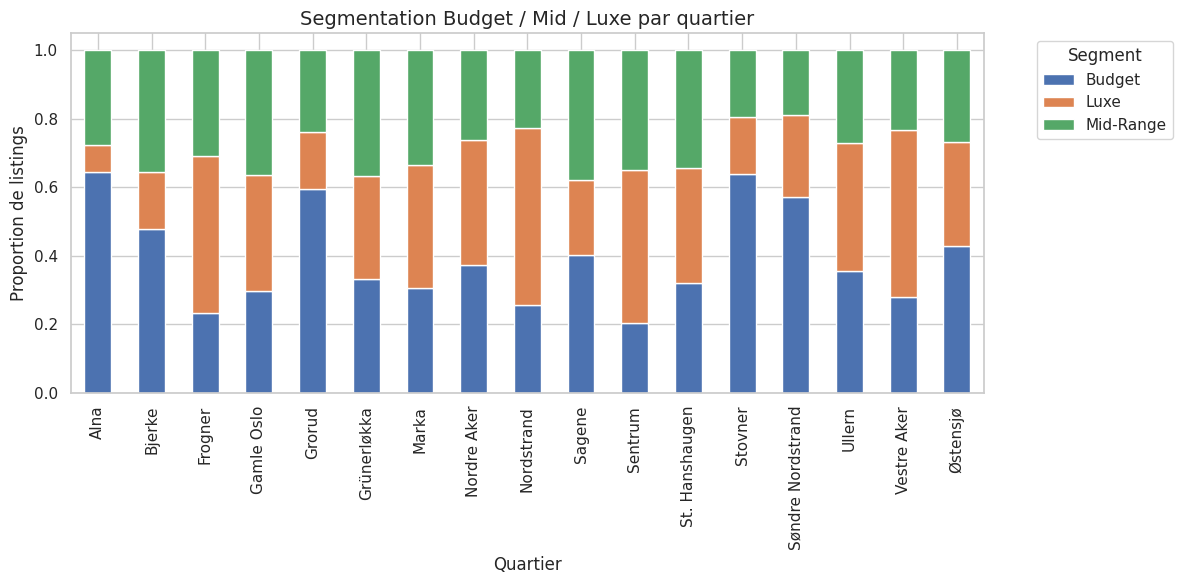

In [ ]:
plt.figure()
ct_norm.plot(kind="bar", stacked=True)
plt.title("Segmentation Budget / Mid / Luxe par quartier")
plt.xlabel("Quartier")
plt.ylabel("Proportion de listings")
plt.legend(title="Segment", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

**Insights : segmentation**
- Certains quartiers sont clairement positionnés **haut de gamme** (forte part de "Luxe") ou alors juste centraux donc plus chère tandis que d’autres plutôt **Budget** ou mixte (les quartiers périphériques).
- Pour un investisseur :
  - entrer sur un quartier déjà très Luxe implique de jouer la carte de la qualité,
  - proposer une offre Luxe dans un quartier très Budget peut être risqué,
    mais aussi différenciant si le produit est vraiment singulier.

## 9. Synthèse business & limites de l’analyse
### 9.1. Principaux enseignements
- **Structure du marché :** Le marché Airbnb d’Oslo est concentré sur quelques quartiers centraux,
  dominés par les logements entiers. Ces zones structurent l’essentiel de l’offre.
- **Prix & localisation :** La variable la plus discriminante est le **quartier** :
  certains affichent des médianes nettement plus élevées
  et concentrent le segment Luxe, d’autres restent beaucoup plus abordables.
- **Type de logement :** Les logements entiers sont naturellement plus chers que les chambres privées,
  ce qui reflète une capacité d’accueil et une intimité supérieures.
- **Hôtes & professionnalisation :** Une part significative des annonces est portée par des hôtes multi-listings.
  Ces hôtes “pros” peuvent pratiquer des prix moyens plus bas,
  suggérant une stratégie volume/standardisation, face à des particuliers
  qui louent des biens plus grands ou plus singuliers.
- **Demande :** Les combinaisons "beaucoup d’avis récents + faible disponibilité"
  indiquent des quartiers très recherchés.  
  Ces zones peuvent être des cibles privilégiées pour un investissement
  si les prix d’acquisition restent acceptables.
- **Segmentation :** La décomposition Budget / Mid / Luxe met en évidence
  des profils de quartiers distincts, utile pour réfléchir à un
  positionnement produit (type de bien, gamme, niveau de service).
### 9.2. Limites & biais
- **Snapshot** : l’analyse repose sur une photographie à un instant donné.
  Impossible d’analyser la saisonnalité fine.
- **Données déclaratives** : les prix affichés ne tiennent pas compte
  des frais annexes, promotions, remises de dernière minute.
- **Prix manquants** : ~30 % des lignes ne renseignent pas le prix
  et ont été exclues de l’analyse économique. C’est un biais potentiel.
- **Absence de certaines variables** : pas de statut de superhost,
  pas d’informations détaillées sur la qualité du bien ou les équipements.

## 10. Usage de l’IA & réflexivité
Conformément au cahier des charges, ce notebook a été co-construit
avec un assistant IA, en jouant pleinement notre rôle de **Business Analyst** :
- On a rédigé un **master prompt structuré** décrivant le contexte,
  les attentes métier et la structure du notebook.
- L’IA a proposé un premier notebook complet ; j’ai ensuite :
  - identifié des choix méthodologiques trop agressifs (filtrage des outliers
    supprimant ~33 % des données),
  - demandé des **ajustements** (passage à une stratégie par percentiles
    pour préserver le segment Luxe),
  - corrigé des interprétations contradictoires (par ex. prix moyens plus bas
    chez les pros, ce qui doit être expliqué plutôt que masqué).
- Les échanges complets (prompts, réponses de l’IA, audit critique)
  sont fournis dans le fichier `interaction_IA_oslo.md` / PDF.
Cette démarche montre une **complémentarité réelle avec l’IA** :
l’outil produit du code et des visualisations rapidement,
mais la **cohérence métier**, les choix de paramétrage
(gestion des outliers, définition d’un hôte pro, lecture des corrélations)
restent une responsabilité humaine.

## 11. Modélisation des Prix (Projet de Groupe)
**Objectif :** Construire un modèle de régression linéaire pour expliquer la formation des prix à Oslo.
**Note :** Cette section est l'extension pour le projet de groupe.

### 11.1. Préparation des Données (Feature Engineering)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1. Sélection des variables pertinentes
features = ['neighbourhood', 'room_type', 'minimum_nights', 'availability_365', 'number_of_reviews']
target = 'price'

# 2. Préparation du dataset (sur base nettoyée)
df_model = df_clean[features + [target]].copy()

# 3. Encodage des variables catégorielles (One-Hot Encoding)
df_model = pd.get_dummies(df_model, columns=['neighbourhood', 'room_type'], drop_first=True)

# 4. Séparation Features (X) / Target (y)
X = df_model.drop(target, axis=1)
y = df_model[target]

print(f"Dimensions pour la modélisation : {X.shape}")


### 11.2. Entraînement & Évaluation
Modèle : **Régression Linéaire Simple**


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² : {r2:.3f}")
print(f"RMSE : {rmse:.2f} {CITY_NAME} Currency")


### 11.3. Impact des Variables (Coefficients)
Influence financière (en devise locale) de chaque caractéristique.


In [ ]:
coefs = pd.DataFrame({
    'Variable': X.columns,
    'Impact': model.coef_
}).sort_values(by='Impact', ascending=False)

display(coefs.head(5))
display(coefs.tail(5))


### 11.4. Conclusion Modélisation
Ce modèle permet de quantifier la valorisation des quartiers et des types de biens, offrant une base pour estimer le prix juste d'un nouvel investissement.
